In [1]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### データ読込

In [2]:
in_dir = '../data/two_years_each/train_val_consistent'

df_train_X = pd.read_excel(os.path.join(in_dir, 'train_X.xlsx'), header=0, index_col=0)
df_train_Y = pd.read_excel(os.path.join(in_dir, 'train_Y.xlsx'), header=0, index_col=0)

df_val_X = pd.read_excel(os.path.join(in_dir, 'val_X.xlsx'), header=0, index_col=0)
df_val_Y = pd.read_excel(os.path.join(in_dir, 'val_Y.xlsx'), header=0, index_col=0)

In [3]:
def sales_sum(row):
    #print(row)
    return sum(v for i, v in row.items() if 'Sales' in i) 

df_train_Y['Sales'] = df_train_Y.apply(lambda x: sales_sum(x), axis=1)
df_train_Y.head()

,SalesRent,SalesRyutsu,SalesSck,SalesMansionBkn,SalesMansionKen,SalesKodateBkn,SalesKodateKen,Impressions,Clicks,Cost,Sales
2018-02-23,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,2,0,0.000000,0.000000
2018-02-01,0.0,0.0,0.000000,0.0,0.0,0.000000,25877.309441,98476,50,774.500006,25877.309441
2018-02-02,0.0,0.0,72.945746,0.0,0.0,0.000000,918.164707,95692,42,650.579987,991.110454
2018-02-03,0.0,0.0,75.928914,0.0,0.0,2741.840787,112272.000000,75471,55,851.949995,115089.769702
2018-02-04,0.0,0.0,75.461330,0.0,0.0,65401.739668,61095.628961,63768,48,743.520008,126572.829959


In [4]:
df_val_Y['Sales'] = df_val_Y.apply(lambda x: sales_sum(x), axis=1)
df_val_Y.head()

,SalesRent,SalesRyutsu,SalesSck,SalesMansionBkn,SalesMansionKen,SalesKodateBkn,SalesKodateKen,Impressions,Clicks,Cost,Sales
2019-11-08,0.0,0.0,812.2125,0.0,0.0,0.000000,0.000000,101648,64,640.0,812.212500
2019-11-09,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,105557,82,820.0,0.000000
2019-11-10,0.0,0.0,0.0000,0.0,0.0,1881.721558,10994.925897,110312,95,950.0,12876.647456
2019-11-11,0.0,0.0,0.0000,0.0,0.0,0.000000,0.000000,118104,66,660.0,0.000000
2019-11-12,0.0,0.0,0.0000,0.0,0.0,3814.646432,514.313868,114748,48,480.0,4328.960300


### 目的変数の分布

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

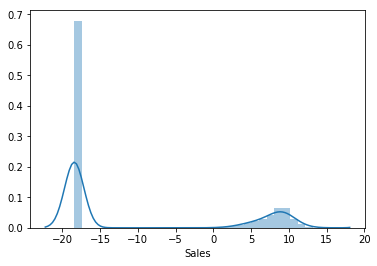

In [5]:
sns.distplot(np.log(df_train_Y['Sales'] + 0.00000001))
plt.plot()

In [6]:
def log(x):
    return np.log(x + 0.00000001)

#for c in ['Sales', 'Impressions', 'Clicks', 'Cost']:
for c in ['Sales']:
    df_train_Y['Sales_log'] = df_train_Y['Sales'].apply(log)
    df_val_Y['Sales_log'] = df_val_Y['Sales'].apply(log)

### データ構造転換

In [7]:
d_train_sales = xgb.DMatrix(df_train_X, label=df_train_Y['Sales_log'])
d_val_sales = xgb.DMatrix(df_val_X, label=df_val_Y['Sales_log'])

d_val = xgb.DMatrix(df_val_X)

C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\dushu\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### xgboost モデルの作成

In [8]:
params = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 1500,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'reg_alpha': 10,
    'reg_lambda':10,
}

evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
evals_result = {}

model = xgb.train(params, 
          d_train_sales, 
          num_boost_round=100, 
          evals=evals,
          evals_result=evals_result)

[0]	train-rmse:15.0009	eval-rmse:13.8505
[1]	train-rmse:13.813	eval-rmse:12.9789
[2]	train-rmse:12.7608	eval-rmse:12.2215
[3]	train-rmse:11.8336	eval-rmse:11.5803
[4]	train-rmse:11.0147	eval-rmse:11.0303
[5]	train-rmse:10.2972	eval-rmse:10.5609
[6]	train-rmse:9.66756	eval-rmse:10.1533
[7]	train-rmse:9.12077	eval-rmse:9.81678
[8]	train-rmse:8.64506	eval-rmse:9.53159
[9]	train-rmse:8.23202	eval-rmse:9.29456
[10]	train-rmse:7.87429	eval-rmse:9.10015
[11]	train-rmse:7.56438	eval-rmse:8.9344
[12]	train-rmse:7.29767	eval-rmse:8.79446
[13]	train-rmse:7.06571	eval-rmse:8.68151
[14]	train-rmse:6.86658	eval-rmse:8.58797
[15]	train-rmse:6.69533	eval-rmse:8.51617
[16]	train-rmse:6.55172	eval-rmse:8.45523
[17]	train-rmse:6.42187	eval-rmse:8.41003
[18]	train-rmse:6.30458	eval-rmse:8.36941
[19]	train-rmse:6.20553	eval-rmse:8.33662
[20]	train-rmse:6.11744	eval-rmse:8.31097
[21]	train-rmse:6.03905	eval-rmse:8.28856
[22]	train-rmse:5.97083	eval-rmse:8.27251
[23]	train-rmse:5.91065	eval-rmse:8.26179
[24]

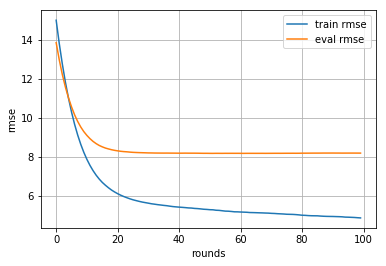

In [9]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

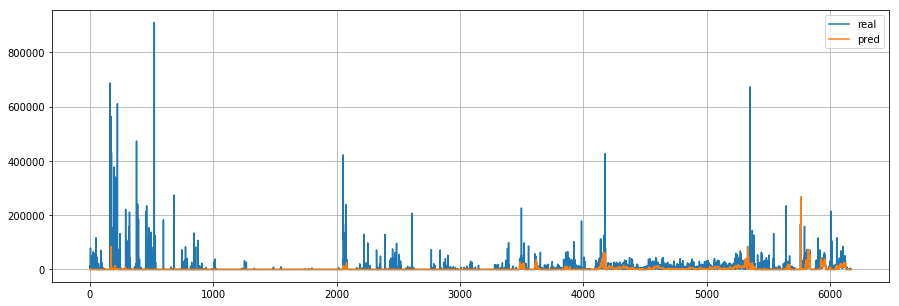

In [13]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['Sales'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

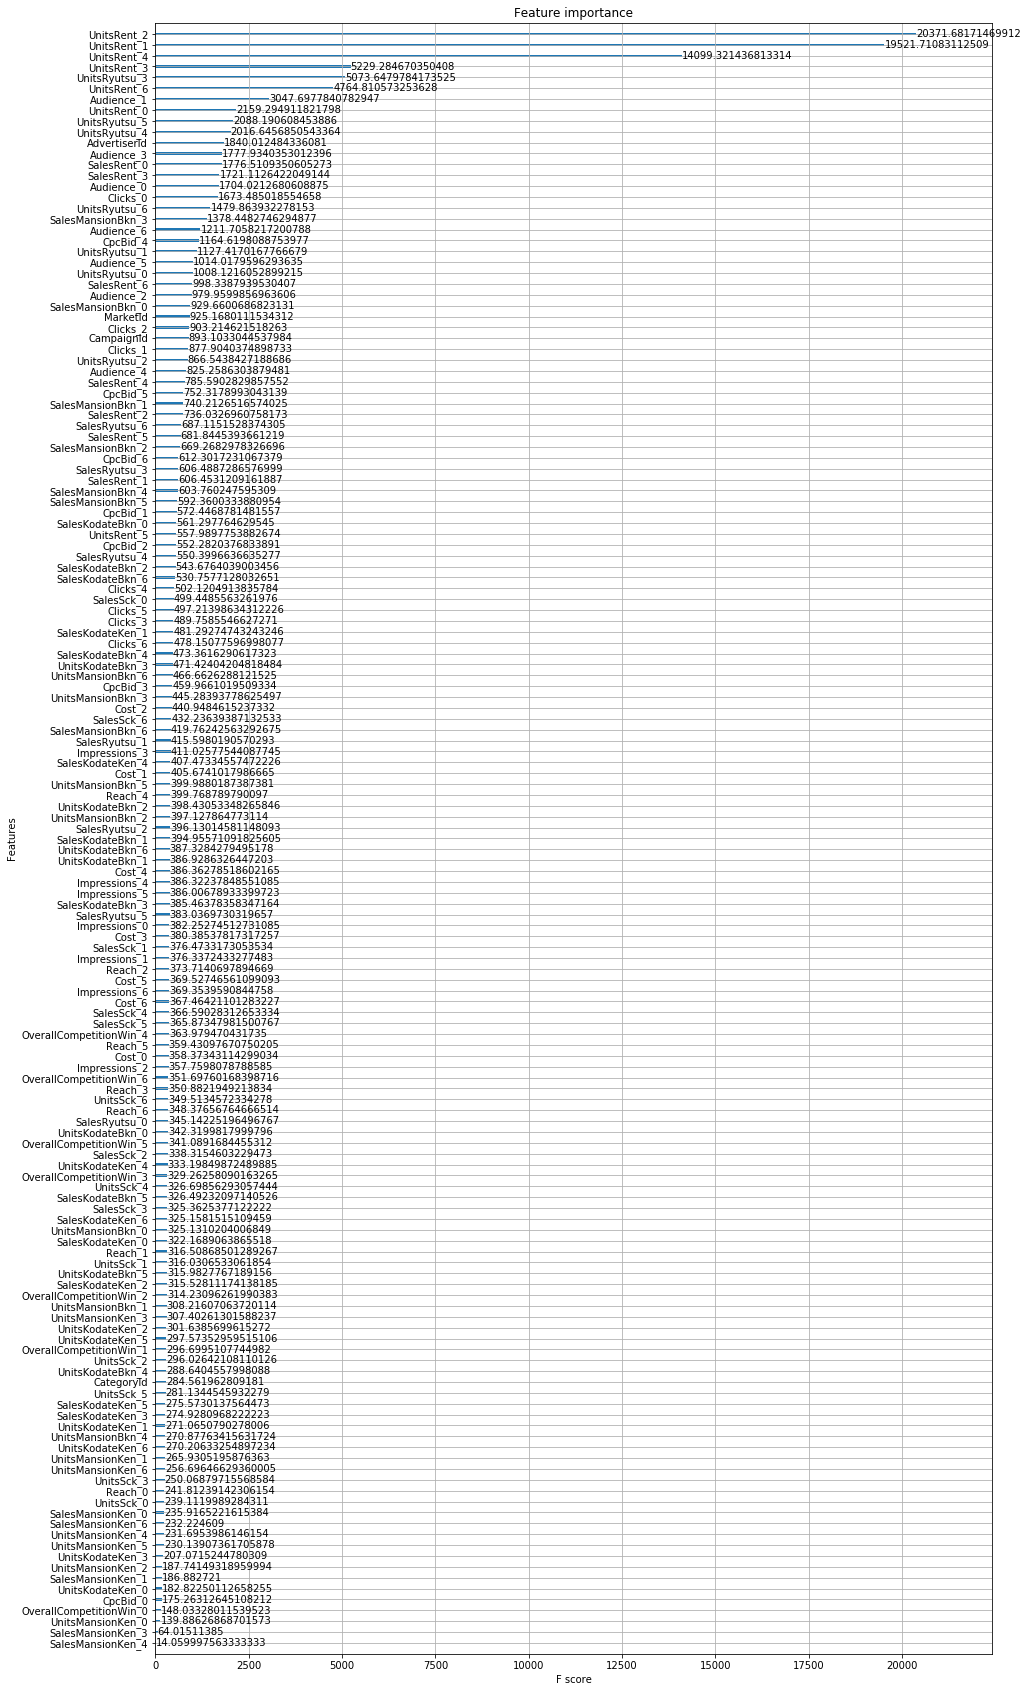

In [11]:
_, ax = plt.subplots(figsize=(15,30))
xgb.plot_importance(model, ax=ax, importance_type='gain')
plt.show()

In [12]:
m = model.get_score(importance_type='gain')
sorted(m, key=lambda x: m[x], reverse=True)

['UnitsRent_2',
 'UnitsRent_1',
 'UnitsRent_4',
 'UnitsRent_3',
 'UnitsRyutsu_3',
 'UnitsRent_6',
 'Audience_1',
 'UnitsRent_0',
 'UnitsRyutsu_5',
 'UnitsRyutsu_4',
 'AdvertiserId',
 'Audience_3',
 'SalesRent_0',
 'SalesRent_3',
 'Audience_0',
 'Clicks_0',
 'UnitsRyutsu_6',
 'SalesMansionBkn_3',
 'Audience_6',
 'CpcBid_4',
 'UnitsRyutsu_1',
 'Audience_5',
 'UnitsRyutsu_0',
 'SalesRent_6',
 'Audience_2',
 'SalesMansionBkn_0',
 'MarketId',
 'Clicks_2',
 'CampaignId',
 'Clicks_1',
 'UnitsRyutsu_2',
 'Audience_4',
 'SalesRent_4',
 'CpcBid_5',
 'SalesMansionBkn_1',
 'SalesRent_2',
 'SalesRyutsu_6',
 'SalesRent_5',
 'SalesMansionBkn_2',
 'CpcBid_6',
 'SalesRyutsu_3',
 'SalesRent_1',
 'SalesMansionBkn_4',
 'SalesMansionBkn_5',
 'CpcBid_1',
 'SalesKodateBkn_0',
 'UnitsRent_5',
 'CpcBid_2',
 'SalesRyutsu_4',
 'SalesKodateBkn_2',
 'SalesKodateBkn_6',
 'Clicks_4',
 'SalesSck_0',
 'Clicks_5',
 'Clicks_3',
 'SalesKodateKen_1',
 'Clicks_6',
 'SalesKodateBkn_4',
 'UnitsKodateBkn_3',
 'UnitsMansionBkn